# Goal: approximate percentile for a hand given its 2 player win rate and the point in the game

At a given point of the game, the win rates for randomly selected pairs of hole/pocket cards should have a normal distribution. We can use this property to estimate the win rate for a given hand. We just need to get the mean (hopefully just 0.5) and standard deviation (should change depending on the point in the game, later stages having wider distributions) of the win rates for the given point in the game.

This will allow us to include a percentile estimate in game statistics.

In [3]:
import pandas as pd
from texas_hold_em_utils.deck import Deck
from texas_hold_em_utils.card import Card
from texas_hold_em_utils.preflop_stats_repository import PreflopStatsRepository

preflop_stats_repo = PreflopStatsRepository()

We already have percentiles for pre-flop, so we can use that to test the validity of the method.

In [4]:
preflop_df = pd.DataFrame(columns=['2_player_win_rate', 'actual_percentile'])

for i in range(10000):
    deck = Deck()
    deck.shuffle()
    hole_cards = [deck.draw(), deck.draw()]
    data = preflop_stats_repo.get_win_rate(hole_cards[0].rank, hole_cards[1].rank, hole_cards[0].suit == hole_cards[1].suit, 2)
    preflop_df = pd.concat([preflop_df, pd.DataFrame({'2_player_win_rate': [data['win_rate']], 'actual_percentile': [data['percentile']]})])

C:\Users\amarl\AppData\Local\Temp\ipykernel_15068\2261782968.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  preflop_df = pd.concat([preflop_df, pd.DataFrame({'2_player_win_rate': [data['win_rate']], 'actual_percentile': [data['percentile']]})])


In [5]:
preflop_df['2_player_win_rate'].mean()

0.5015931876953813

In [6]:
preflop_df['2_player_win_rate'].std()

0.10339163255712572

<Axes: >

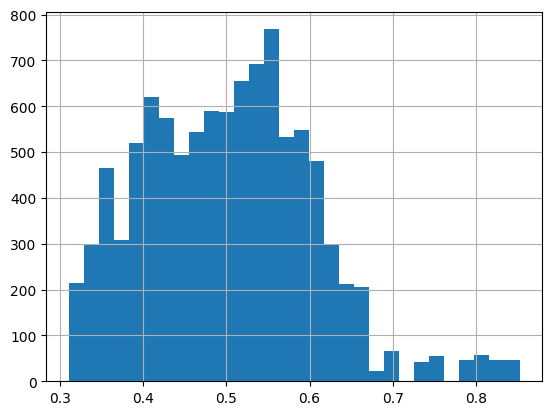

In [7]:
preflop_df['2_player_win_rate'].hist(bins=30)

The distribution isn't perfectly normal, there are some outliers on the high end. But it seems pretty good and the average win rate is almost exactly 0.5. We've got our mean and standard deviation, let's calculate expected percentile.

In [8]:
from scipy.stats import norm

def expected_percentile(win_rate, mean, std_dev):
    z_score = (win_rate - mean) / std_dev
    return norm.cdf(z_score) * 100

In [9]:
preflop_df['expected_percentile'] = preflop_df['2_player_win_rate'].apply(lambda x: expected_percentile(x, 0.5, 0.10241956631062014))
preflop_df['percentile_error'] = preflop_df['actual_percentile'] - preflop_df['expected_percentile']

In [10]:
preflop_df['percentile_error'].mean()

-0.24704749387218566

In [11]:
preflop_df['percentile_error'].std()

1.3660607458671792

<Axes: >

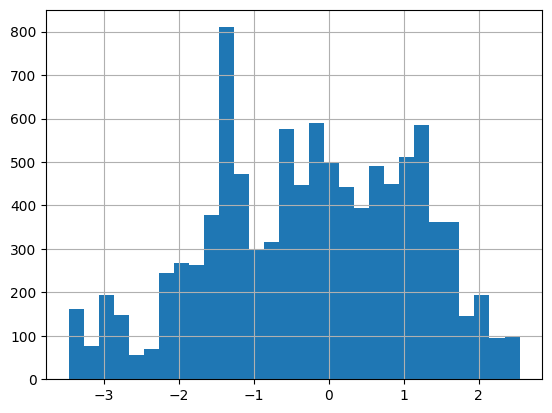

In [12]:
preflop_df['percentile_error'].hist(bins=30)

Text(0, 0.5, 'Expected percentile')

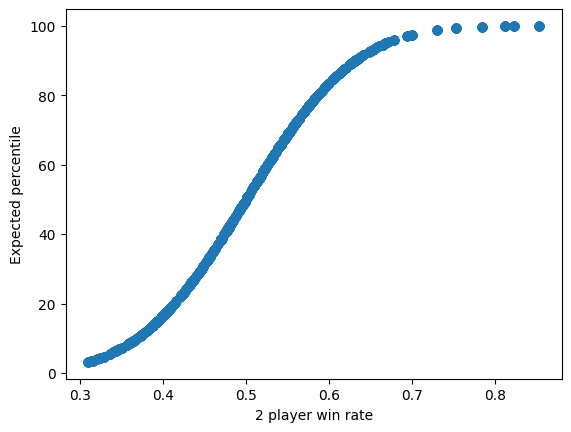

In [22]:
# scatter plot of win rate vs expected percentile

import matplotlib.pyplot as plt

plt.scatter(preflop_df['2_player_win_rate'], preflop_df['expected_percentile'])
plt.xlabel('2 player win rate')
plt.ylabel('Expected percentile')

Estimate using this method comes within 3% of the actual value from our simulations. Now we just need the distribution for later points in the game.

In [15]:
from texas_hold_em_utils.hands import HandOfFive
import copy

def rank_hand_post_river(hand, community_cards):
    player_hand = HandOfFive(hand, community_cards)
    deck1 = Deck()
    deck2 = Deck()
    wins = 0
    losses = 0
    ties = 0
    for card1 in deck1.cards:
        if card1 not in hand + community_cards:
            for card2 in deck2.cards:
                if card2 not in hand + community_cards and card2 != card1:
                    other_hand = HandOfFive([card1, card2], community_cards)
                    if player_hand > other_hand:
                        wins += 1
                    elif player_hand < other_hand:
                        losses += 1
                    else:
                        ties += 1
    return (wins + (0.5 * ties)) / (wins + losses + ties)


def rank_hand_post_turn(hand, flop_and_turn, n_other_players=1, sample_size=1000):
    deck = Deck()
    deck.remove(hand[0])
    deck.remove(hand[1])

    deck.remove(flop_and_turn[0])
    deck.remove(flop_and_turn[1])
    deck.remove(flop_and_turn[2])
    deck.remove(flop_and_turn[3])

    wins = 0.0

    for i in range(sample_size):
        deck_cpy = copy.deepcopy(deck)
        deck_cpy.shuffle()

        river = deck_cpy.draw()

        comm = [flop_and_turn[0], flop_and_turn[1], flop_and_turn[2], flop_and_turn[3], river]

        other_hands = []
        for j in range(n_other_players):
            other_hands.append(HandOfFive([deck_cpy.draw(), deck_cpy.draw()], comm))

        player_hand = HandOfFive(hand, comm)

        lost_to = []
        tied_with = []

        for hand_obj in other_hands:
            if player_hand < hand_obj:
                lost_to.append(hand_obj)
            elif player_hand == hand_obj:
                tied_with.append(hand_obj)

        if len(lost_to) == 0:
            wins += 1 / (len(tied_with) + 1)

    return wins / sample_size


def rank_hand_post_flop(hand, flop, n_other_players=1, sample_size=1000):
    deck = Deck()
    deck.remove(hand[0])
    deck.remove(hand[1])

    deck.remove(flop[0])
    deck.remove(flop[1])
    deck.remove(flop[2])

    wins = 0.0

    for i in range(sample_size):
        deck_cpy = copy.deepcopy(deck)
        deck_cpy.shuffle()

        turn = deck_cpy.draw()
        river = deck_cpy.draw()

        comm = [flop[0], flop[1], flop[2], turn, river]

        other_hands = []
        for j in range(n_other_players):
            other_hands.append(HandOfFive([deck_cpy.draw(), deck_cpy.draw()], comm))

        player_hand = HandOfFive(hand, comm)

        lost_to = []
        tied_with = []

        for hand_obj in other_hands:
            if player_hand < hand_obj:
                lost_to.append(hand_obj)
            elif player_hand == hand_obj:
                tied_with.append(hand_obj)

        if len(lost_to) == 0:
            wins += 1 / (len(tied_with) + 1)

    return wins / sample_size


In [17]:
postflop_df = pd.DataFrame(columns=['post_flop_win_rate', 'post_turn_win_rate', 'post_river_win_rate'])

for i in range(1500):
    deck = Deck()
    deck.shuffle()
    hole_cards = [deck.draw(), deck.draw()]
    flop_1 = deck.draw()
    flop_2 = deck.draw()
    flop_3 = deck.draw()
    turn = deck.draw()
    river = deck.draw()
    postflop_df = pd.concat([postflop_df, pd.DataFrame({
        'post_flop_win_rate': [rank_hand_post_flop(hole_cards, [flop_1, flop_2, flop_3])], 
        'post_turn_win_rate': [rank_hand_post_turn(hole_cards, [flop_1, flop_2, flop_3, turn])],
        'post_river_win_rate': [rank_hand_post_river(hole_cards, [flop_1, flop_2, flop_3, turn, river])]
        })])

C:\Users\amarl\AppData\Local\Temp\ipykernel_15068\1079982586.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  postflop_df = pd.concat([postflop_df, pd.DataFrame({


In [18]:
print(f"post_flop_mean: {postflop_df['post_flop_win_rate'].mean()}")
print(f"post_flop_std: {postflop_df['post_flop_win_rate'].std()}")
print(f"post_turn_mean: {postflop_df['post_turn_win_rate'].mean()}")
print(f"post_turn_std: {postflop_df['post_turn_win_rate'].std()}")
print(f"post_river_mean: {postflop_df['post_river_win_rate'].mean()}")
print(f"post_river_std: {postflop_df['post_river_win_rate'].std()}")

post_flop_mean: 0.49821333333333334
post_flop_std: 0.20277154473723782
post_turn_mean: 0.49590566666666663
post_turn_std: 0.23895325562434003
post_river_mean: 0.5071215488215488
post_river_std: 0.29411125409761246


<Axes: >

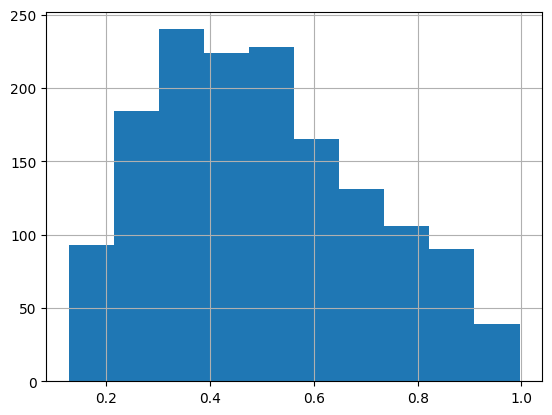

In [19]:
postflop_df['post_flop_win_rate'].hist()

<Axes: >

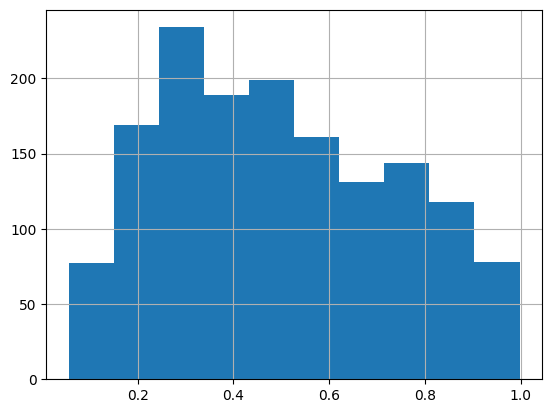

In [20]:
postflop_df['post_turn_win_rate'].hist()

<Axes: >

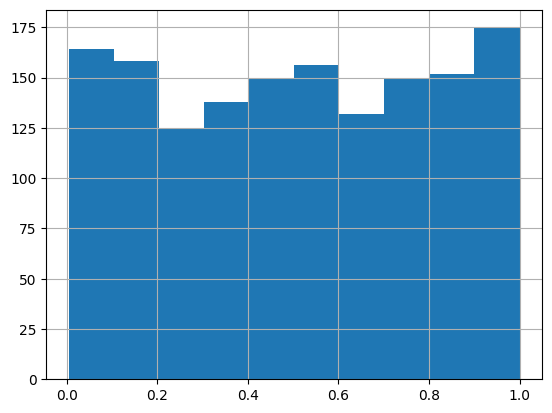

In [21]:
postflop_df['post_river_win_rate'].hist()

In [23]:
postflop_df['post_flop_percentile'] = postflop_df['post_flop_win_rate'].apply(lambda x: expected_percentile(x, 0.5, 0.20277154473723782))

postflop_df['post_turn_percentile'] = postflop_df['post_turn_win_rate'].apply(lambda x: expected_percentile(x, 0.5, 0.23895325562434003))

postflop_df['post_river_percentile'] = postflop_df['post_river_win_rate'].apply(lambda x: expected_percentile(x, 0.5, 0.29411125409761246))

Text(0, 0.5, 'Expected percentile')

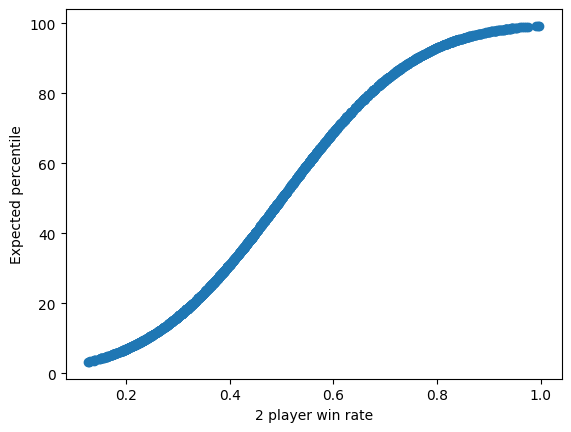

In [25]:
plt.scatter(postflop_df['post_flop_win_rate'], postflop_df['post_flop_percentile'])
plt.xlabel('2 player win rate')
plt.ylabel('Expected percentile')

Text(0, 0.5, 'Expected percentile')

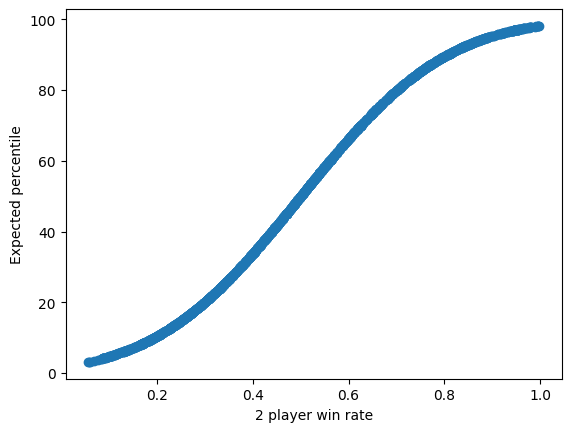

In [26]:
plt.scatter(postflop_df['post_turn_win_rate'], postflop_df['post_turn_percentile'])
plt.xlabel('2 player win rate')
plt.ylabel('Expected percentile')

Text(0, 0.5, 'Expected percentile')

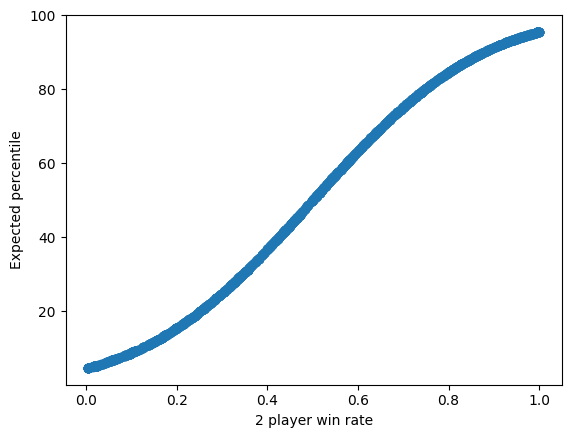

In [27]:
plt.scatter(postflop_df['post_river_win_rate'], postflop_df['post_river_percentile'])
plt.xlabel('2 player win rate')
plt.ylabel('Expected percentile')

Estimates seem pretty good, think we can use this method to predict percentiles.